In [210]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
import time
import sys
import re
import os
import plotly.graph_objects as go
import config
import pickle
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from umap import UMAP
from dbcv import *

## Join Hot and Not-hot songs dfs into one before clustering

In [211]:
not_hot_100_songs = pd.read_csv("../../../Day_1/Afternoon/lab-not-hot-songs/not_hot_songs_db.csv")
display(not_hot_100_songs.head())
display(not_hot_100_songs.columns)
"""
Remove: ['track_href', 'uri', 'analysis_url', 'genre',  'Rank', 'title']
Rename: {'artist_name':'artist'}
Add: Hot indicator column = False
"""

not_hot_100_songs = not_hot_100_songs.rename(columns={'artist_name':'artist'}).drop(columns=['track_href', 'uri', 'analysis_url', 'genre',  'title', 'song_key', 'type', 'song_ids'])
not_hot_100_songs['hot_song'] = True
not_hot_100_songs.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,track_href,analysis_url,duration_ms,time_signature,genre,song_name,title,song_key,song_ids,artist_name
0,0.749,0.802,10,-5.780,0,0.202,0.105000,0.000000,0.2960,0.4700,...,https://api.spotify.com/v1/tracks/5q62CK2DoFxd...,https://api.spotify.com/v1/audio-analysis/5q62...,174357,4,Underground Rap,big tyma,NaN,big tyma_alkaline,5q62CK2DoFxdFBzFDCctDE,Alkaline
1,0.464,0.602,7,-8.185,1,0.125,0.860000,0.000000,0.1620,0.6640,...,https://api.spotify.com/v1/tracks/1npAOCsqbB61...,https://api.spotify.com/v1/audio-analysis/1npA...,162373,4,Underground Rap,mozambique drill,NaN,mozambique drill_mach-hommy,1npAOCsqbB618Zz4jOQxZL,Mach-Hommy
2,0.577,0.692,11,-5.960,1,0.640,0.372000,0.059600,0.0989,0.0658,...,https://api.spotify.com/v1/tracks/5zjdL4aLh3D3...,https://api.spotify.com/v1/audio-analysis/5zjd...,122483,4,Underground Rap,2000 rounds,NaN,2000 rounds_ghostemane,5zjdL4aLh3D3wOKeRkZSL6,Ghostemane
3,0.642,0.694,11,-6.104,1,0.364,0.000335,0.000000,0.3120,0.5680,...,https://api.spotify.com/v1/tracks/2TF0kVvksniU...,https://api.spotify.com/v1/audio-analysis/2TF0...,143331,4,Underground Rap,85 to africa,NaN,85 to africa_jidenna,2TF0kVvksniUGEdwnBSw2v,Jidenna
4,0.789,0.488,4,-9.093,0,0.227,0.179000,0.000008,0.1040,0.0644,...,https://api.spotify.com/v1/tracks/23NWj2izXAJ4...,https://api.spotify.com/v1/audio-analysis/23NW...,209453,4,Underground Rap,pop style,NaN,pop style_drake,23NWj2izXAJ4yL6Nah73wf,Drake


Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre', 'song_name', 'title', 'song_key', 'song_ids',
       'artist_name'],
      dtype='object')

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,song_name,artist,hot_song
0,0.749,0.802,10,-5.780,0,0.202,0.105000,0.000000,0.2960,0.4700,203.934,5q62CK2DoFxdFBzFDCctDE,174357,4,big tyma,Alkaline,True
1,0.464,0.602,7,-8.185,1,0.125,0.860000,0.000000,0.1620,0.6640,166.748,1npAOCsqbB618Zz4jOQxZL,162373,4,mozambique drill,Mach-Hommy,True
2,0.577,0.692,11,-5.960,1,0.640,0.372000,0.059600,0.0989,0.0658,144.702,5zjdL4aLh3D3wOKeRkZSL6,122483,4,2000 rounds,Ghostemane,True
3,0.642,0.694,11,-6.104,1,0.364,0.000335,0.000000,0.3120,0.5680,106.410,2TF0kVvksniUGEdwnBSw2v,143331,4,85 to africa,Jidenna,True
4,0.789,0.488,4,-9.093,0,0.227,0.179000,0.000008,0.1040,0.0644,133.114,23NWj2izXAJ4yL6Nah73wf,209453,4,pop style,Drake,True


In [212]:
top_100_hot_songs_df = pd.read_csv("../../../Day_2/Morning/lab-spotify-api/top_100_songs.csv")
display(top_100_hot_songs_df.head())
display(top_100_hot_songs_df.columns)

"""
Remove: ['Title', 'Rank', 'track_href', 'uri', 'analysis_url' ]
Rename: {'Artist':'artist'}
Add: Hot indicator column = True
"""
top_100_hot_songs_df = top_100_hot_songs_df.rename(columns={'Artist':'artist'}).drop(columns=['Title', 'Rank', 'track_href', 'uri', 'analysis_url', 'type', 'original'])
top_100_hot_songs_df['hot_song'] = False
display(top_100_hot_songs_df.head())

,Title,Artist,Rank,danceability,energy,key,loudness,mode,speechiness,acousticness,...,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,song_name,original
0,Lovin On Me,Jack Harlow,1,0.943,0.558,2,-4.911,1,0.0568,0.0026,...,104.983,audio_features,4xhsWYTOGcal8zt0J161CU,spotify:track:4xhsWYTOGcal8zt0J161CU,https://api.spotify.com/v1/tracks/4xhsWYTOGcal...,https://api.spotify.com/v1/audio-analysis/4xhs...,138411,4,Lovin On Me,Lovin On Me
1,Cruel Summer,Taylor Swift,2,0.552,0.702,9,-5.707,1,0.1570,0.1170,...,169.994,audio_features,1BxfuPKGuaTgP7aM0Bbdwr,spotify:track:1BxfuPKGuaTgP7aM0Bbdwr,https://api.spotify.com/v1/tracks/1BxfuPKGuaTg...,https://api.spotify.com/v1/audio-analysis/1Bxf...,178427,4,Cruel Summer,Cruel Summer
2,Greedy,Tate McRae,3,0.750,0.733,6,-3.180,0,0.0319,0.2560,...,111.018,audio_features,3rUGC1vUpkDG9CZFHMur1t,spotify:track:3rUGC1vUpkDG9CZFHMur1t,https://api.spotify.com/v1/tracks/3rUGC1vUpkDG...,https://api.spotify.com/v1/audio-analysis/3rUG...,131872,1,greedy,Greedy
3,Paint The Town Red,Doja Cat,4,0.868,0.538,5,-8.603,1,0.1740,0.2690,...,99.968,audio_features,2IGMVunIBsBLtEQyoI1Mu7,spotify:track:2IGMVunIBsBLtEQyoI1Mu7,https://api.spotify.com/v1/tracks/2IGMVunIBsBL...,https://api.spotify.com/v1/audio-analysis/2IGM...,231750,4,Paint The Town Red,Paint The Town Red
4,I Remember Everything,Zach Bryan Featuring Kacey Musgraves,5,0.429,0.453,0,-7.746,1,0.0459,0.5540,...,77.639,audio_features,4KULAymBBJcPRpk1yO4dOG,spotify:track:4KULAymBBJcPRpk1yO4dOG,https://api.spotify.com/v1/tracks/4KULAymBBJcP...,https://api.spotify.com/v1/audio-analysis/4KUL...,227196,4,I Remember Everything (feat. Kacey Musgraves),I Remember Everything


Index(['Title', 'Artist', 'Rank', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature', 'song_name', 'original'],
      dtype='object')

,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,song_name,hot_song
0,Jack Harlow,0.943,0.558,2,-4.911,1,0.0568,0.0026,0.000002,0.0937,0.606,104.983,4xhsWYTOGcal8zt0J161CU,138411,4,Lovin On Me,False
1,Taylor Swift,0.552,0.702,9,-5.707,1,0.1570,0.1170,0.000021,0.1050,0.564,169.994,1BxfuPKGuaTgP7aM0Bbdwr,178427,4,Cruel Summer,False
2,Tate McRae,0.750,0.733,6,-3.180,0,0.0319,0.2560,0.000000,0.1140,0.844,111.018,3rUGC1vUpkDG9CZFHMur1t,131872,1,greedy,False
3,Doja Cat,0.868,0.538,5,-8.603,1,0.1740,0.2690,0.000003,0.0901,0.732,99.968,2IGMVunIBsBLtEQyoI1Mu7,231750,4,Paint The Town Red,False
4,Zach Bryan Featuring Kacey Musgraves,0.429,0.453,0,-7.746,1,0.0459,0.5540,0.000002,0.1020,0.155,77.639,4KULAymBBJcPRpk1yO4dOG,227196,4,I Remember Everything (feat. Kacey Musgraves),False


In [213]:
songs_df = pd.concat([not_hot_100_songs,top_100_hot_songs_df])

# Saving df to local machine
songs_df.to_csv("./songs_with_features.csv", index=False)


In [214]:
display(songs_df.head())
X_num = songs_df.select_dtypes(np.number)

# Saving df for clustering to local machine
X_num.to_csv("./songs_clusters.csv", index=False)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,song_name,artist,hot_song
0,0.749,0.802,10,-5.780,0,0.202,0.105000,0.000000,0.2960,0.4700,203.934,5q62CK2DoFxdFBzFDCctDE,174357,4,big tyma,Alkaline,True
1,0.464,0.602,7,-8.185,1,0.125,0.860000,0.000000,0.1620,0.6640,166.748,1npAOCsqbB618Zz4jOQxZL,162373,4,mozambique drill,Mach-Hommy,True
2,0.577,0.692,11,-5.960,1,0.640,0.372000,0.059600,0.0989,0.0658,144.702,5zjdL4aLh3D3wOKeRkZSL6,122483,4,2000 rounds,Ghostemane,True
3,0.642,0.694,11,-6.104,1,0.364,0.000335,0.000000,0.3120,0.5680,106.410,2TF0kVvksniUGEdwnBSw2v,143331,4,85 to africa,Jidenna,True
4,0.789,0.488,4,-9.093,0,0.227,0.179000,0.000008,0.1040,0.0644,133.114,23NWj2izXAJ4yL6Nah73wf,209453,4,pop style,Drake,True


# Dimensionality Reduction Techniques

In [215]:
# Scale numericals before going through dimensionality reduction techniques
scaler = StandardScaler()
scaler.fit(X_num)
X_scaled = scaler.transform(X_num)

path = "scalers/"
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)
    print("The new directory is created!")

filename = "standard_scaler.pickle"
with open(path+filename, "wb") as file:
    pickle.dump(scaler, file)


with open(filename, "wb") as file:
        pickle.dump(scaler,file)

X_scaled_df = pd.DataFrame(X_scaled, columns = X_num.columns)
display(X_num.head())
print()
display(X_scaled_df.head())
display(X_scaled_df.describe())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.749,0.802,10,-5.780,0,0.202,0.105000,0.000000,0.2960,0.4700,203.934,174357,4
1,0.464,0.602,7,-8.185,1,0.125,0.860000,0.000000,0.1620,0.6640,166.748,162373,4
2,0.577,0.692,11,-5.960,1,0.640,0.372000,0.059600,0.0989,0.0658,144.702,122483,4
3,0.642,0.694,11,-6.104,1,0.364,0.000335,0.000000,0.3120,0.5680,106.410,143331,4
4,0.789,0.488,4,-9.093,0,0.227,0.179000,0.000008,0.1040,0.0644,133.114,209453,4


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.548183,0.739928,1.321553,0.304074,-1.216700,0.302554,-0.293402,-0.285696,0.639797,0.102863,1.806130,-0.448273,0.110677
1,-1.265486,-0.396237,0.505355,-0.574889,0.821895,-0.260900,3.255804,-0.285696,-0.233249,0.949581,0.579012,-0.654423,0.110677
2,-0.546382,0.115037,1.593619,0.238289,0.821895,3.507658,0.961748,0.041657,-0.644362,-1.661277,-0.148493,-1.340613,0.110677
3,-0.132738,0.126399,1.593619,0.185661,0.821895,1.488003,-0.785425,-0.285696,0.744041,0.530587,-1.412108,-0.981985,0.110677
4,0.802733,-1.043852,-0.310843,-0.906738,-1.216700,0.485494,0.054467,-0.285652,-0.611134,-1.667387,-0.530891,0.155450,0.110677


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,3.031000e+03,3.031000e+03,3.031000e+03,3.031000e+03,3.031000e+03,3.031000e+03,3.031000e+03,3.031000e+03,3.031000e+03,3.031000e+03,3.031000e+03,3.031000e+03,3.031000e+03
mean,5.438664e-16,-2.438022e-16,1.640976e-17,2.062942e-16,-7.032756e-17,-4.688504e-17,-6.095055e-17,-5.626204e-17,1.605813e-16,-1.781631e-16,6.563905e-16,1.406551e-16,-2.496628e-16
std,1.000165e+00,1.000165e+00,1.000165e+00,1.000165e+00,1.000165e+00,1.000165e+00,1.000165e+00,1.000165e+00,1.000165e+00,1.000165e+00,1.000165e+00,1.000165e+00,1.000165e+00
min,-3.543709e+00,-3.540575e+00,-1.399107e+00,-6.608484e+00,-1.216700e+00,-1.005831e+00,-7.869945e-01,-2.856958e-01,-1.151901e+00,-1.820146e+00,-3.010700e+00,-2.575085e+00,-8.874879e+00
25%,-7.054758e-01,-6.745980e-01,-1.127041e+00,-5.701375e-01,-1.216700e+00,-8.045969e-01,-7.127251e-01,-2.856958e-01,-6.306800e-01,-7.874994e-01,-7.628440e-01,-6.731386e-01,1.106766e-01
50%,1.027207e-01,5.822876e-02,-3.877682e-02,1.505754e-01,8.218950e-01,-4.292047e-01,-4.179765e-01,-2.856958e-01,-4.287068e-01,-2.370781e-02,-1.130519e-01,-3.118188e-03,1.106766e-01
75%,7.454597e-01,7.626514e-01,7.774213e-01,6.903791e-01,8.218950e-01,6.830687e-01,3.271216e-01,-2.849708e-01,4.117624e-01,7.466305e-01,8.040851e-01,5.759979e-01,1.106766e-01
max,2.069120e+00,1.853370e+00,1.593619e+00,2.617884e+00,8.218950e-01,5.732204e+00,3.810514e+00,5.069484e+00,4.998509e+00,2.324406e+00,2.341381e+00,8.999376e+00,3.105862e+00


In [216]:
def visualize_dimensionality_reduction(df: pd.DataFrame, models: list, random_state: int = None):
    '''
    Visualize dimensionality reduction results for different models.

    Inputs:
    - df: pd.DataFrame
        The input DataFrame (assumed to be already scaled).
    - models: list
        List of dimensionality reduction models to visualize.
    - random_state: int or None, optional
        Random state for reproducibility.

    Returns:
    - None (displays scatterplot)
    '''

    models_folder = 'models'
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)

    num_models = len(models)
    fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(5 * num_models, 5))

    for i, model in enumerate(models):
        model_instance = None

        if model in [UMAP, TSNE]:
            # UMAP and TSNE do not support random_state during initialization
            model_instance = model()
        else:
            try:
                # Try to provide random_state if the model supports it
                model_instance = model(random_state=random_state)
            except TypeError:
                # If the model does not support random_state, initialize without it
                model_instance = model()

        # Fit and transform the data
        reduced_data = model_instance.fit_transform(df)

        # Create a scatterplot for the current model using Seaborn
        sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], ax=axes[i])
        axes[i].set_title(f'{model.__name__} Scatterplot')
        axes[i].set_xlabel('Component 1')
        axes[i].set_ylabel('Component 2')

        # Save the model as a pickle file in the "models" folder
        model_filename = os.path.join(models_folder, f'{model.__name__}.pkl')
        with open(model_filename, 'wb') as model_file:
            pickle.dump(model_instance, model_file)

        print(f'Saved {model.__name__} model as {model_filename}')

    plt.tight_layout()
    plt.show()

Saved UMAP model as models/UMAP.pkl
Saved TSNE model as models/TSNE.pkl
Saved PCA model as models/PCA.pkl


/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:383: UserWarning:

The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



Saved Isomap model as models/Isomap.pkl


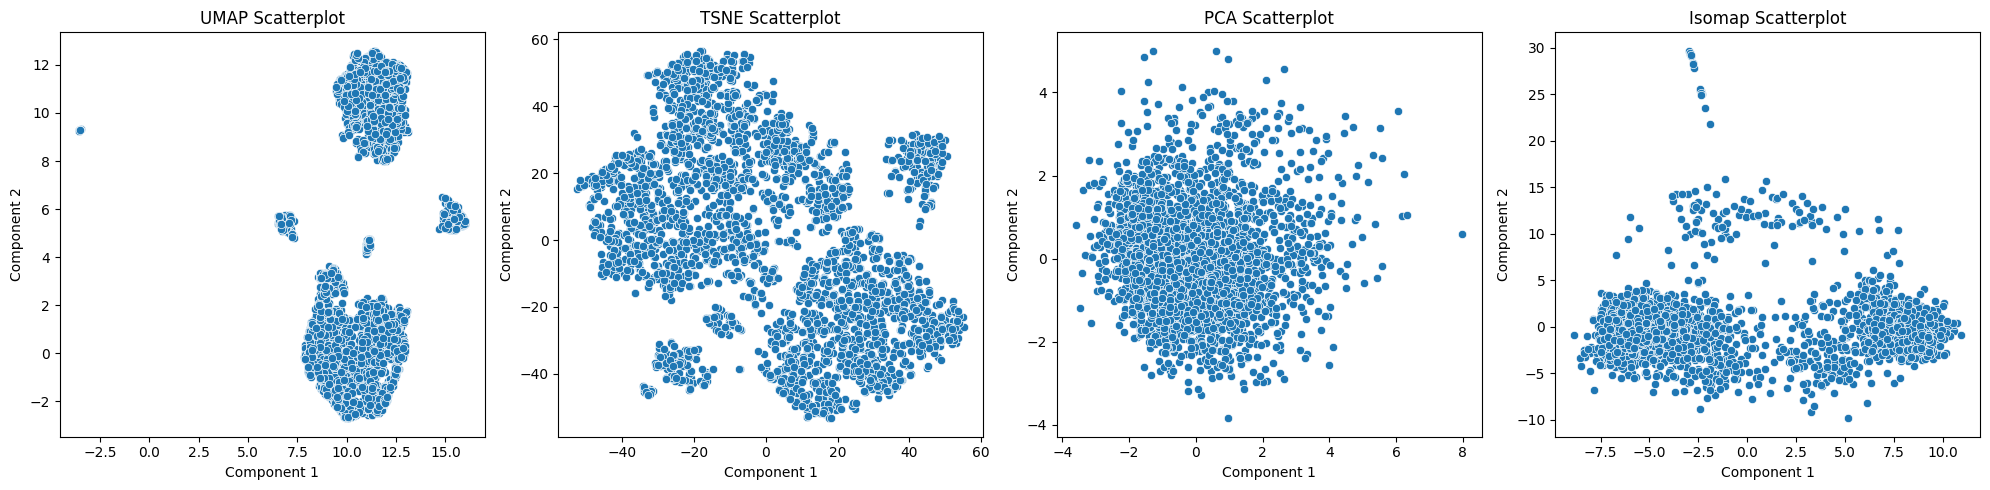

In [217]:
visualize_dimensionality_reduction(X_scaled_df, models=[UMAP, TSNE, PCA, Isomap], random_state=69)

Recommend using UMAP for dimensionality reduction from the above results. 

# Clustering

## K Means

In [218]:
# KMeans not working in my jupyter for some reason, not yet sure. 
kmeans = KMeans(n_clusters=8, random_state=15)
kmeans.fit(X_scaled_df)

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(random_state=15)

In [219]:
clusters = kmeans.predict(X_scaled_df)
#clusters
pd.Series(clusters).value_counts().sort_index() # Number of wines in each cluster

0    109
1    398
2    647
3    161
4    720
5    243
6    457
7    296
Name: count, dtype: int64

In [220]:
X_num['cluster'] = clusters
X_num

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
0,0.749,0.802,10,-5.780,0,0.2020,0.105000,0.000000,0.2960,0.4700,203.934,174357,4,4
1,0.464,0.602,7,-8.185,1,0.1250,0.860000,0.000000,0.1620,0.6640,166.748,162373,4,7
2,0.577,0.692,11,-5.960,1,0.6400,0.372000,0.059600,0.0989,0.0658,144.702,122483,4,1
3,0.642,0.694,11,-6.104,1,0.3640,0.000335,0.000000,0.3120,0.5680,106.410,143331,4,1
4,0.789,0.488,4,-9.093,0,0.2270,0.179000,0.000008,0.1040,0.0644,133.114,209453,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.593,0.397,6,-8.309,1,0.0329,0.684000,0.000007,0.0982,0.3200,76.703,189053,4,7
96,0.728,0.589,7,-7.115,1,0.0376,0.424000,0.000008,0.1660,0.7670,77.475,179013,4,2
97,0.730,0.849,1,-5.281,0,0.0299,0.002340,0.000026,0.3120,0.8870,117.310,230013,4,4
98,0.920,0.696,6,-3.356,0,0.0742,0.183000,0.000000,0.1490,0.5450,106.966,170480,4,4


In [221]:
pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_num.columns[:-1])

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.561248,0.640789,4.614679,-6.423771,6.330275e-01,0.133254,0.241742,0.022008,0.189473,0.329314,145.430174,186152.165138,2.651376
1,0.764181,0.564320,4.161209,-8.612232,7.682620e-01,0.360089,0.154971,0.009280,0.162398,0.442851,150.416076,168893.382872,4.027708
2,0.749380,0.686842,4.843895,-5.877566,1.000000e+00,0.123102,0.118565,0.012819,0.157240,0.520841,147.776550,203228.394127,4.006182
3,0.576286,0.650143,5.409938,-8.699025,5.217391e-01,0.062194,0.136478,0.763714,0.188099,0.219218,143.918907,205917.161491,3.962733
4,0.723319,0.692319,6.747222,-6.221967,-2.220446e-16,0.145235,0.135535,0.006323,0.164887,0.532734,147.806078,208797.375000,4.019444
5,0.599971,0.782535,4.732510,-5.231819,7.119342e-01,0.224973,0.097443,0.021863,0.585255,0.462321,152.410189,190137.135802,4.028807
6,0.481978,0.834954,4.338428,-4.528489,7.641921e-01,0.112396,0.056827,0.011055,0.176599,0.402319,155.928552,214578.729258,4.010917
7,0.606784,0.412494,4.837838,-9.774341,6.114865e-01,0.098265,0.586427,0.018231,0.137067,0.300592,145.304416,204947.716216,4.000000


## Playing with Parameters

In [222]:
kmeans.inertia_

24644.132553014693

In [223]:
kmeans2 = KMeans(n_clusters=8, # Number of clusters/groups
                init="random",
                n_init=3, # Number starting locations for the centroids
                max_iter=2, # Maximum amount of times the centroid's locations are going to be updated (default value = 300)
                tol=0, # Maximum displacement of the centroid's location
                algorithm="full",
                random_state=1234)

kmeans2.fit(X_scaled_df)
print(kmeans2.inertia_)

27585.787313493827


/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.



Training a K-Means model with 2 clusters! 

Initialization complete
Iteration 0, inertia 48442.53923455683.
Iteration 1, inertia 37550.43508508193.
Iteration 2, inertia 36584.128710540725.
Iteration 3, inertia 35714.76970269145.
Iteration 4, inertia 35255.10365071537.
Iteration 5, inertia 35089.161857350424.
Iteration 6, inertia 35029.69559812933.
Iteration 7, inertia 35005.928070061884.
Iteration 8, inertia 34998.827514325516.
Iteration 9, inertia 34995.42735217013.
Iteration 10, inertia 34993.81314593273.
Iteration 11, inertia 34993.435892298556.
Converged at iteration 11: center shift 9.594928047705097e-06 within tolerance 0.00010000000000000067.
Initialization complete
Iteration 0, inertia 54360.94059832732.
Iteration 1, inertia 36202.36150938639.
Iteration 2, inertia 35766.64439947829.
Iteration 3, inertia 35571.64833325759.
Iteration 4, inertia 35430.8106510635.
Iteration 5, inertia 35293.90672772301.
Iteration 6, inertia 35197.89727004866.


/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Iteration 7, inertia 35148.07015482586.
Iteration 8, inertia 35106.06392084315.
Iteration 9, inertia 35075.78109779641.
Iteration 10, inertia 35040.209828038.
Iteration 11, inertia 35019.43308286925.
Iteration 12, inertia 35009.4398104422.
Iteration 13, inertia 35001.411237597.
Iteration 14, inertia 34995.5065427566.
Iteration 15, inertia 34993.72214615873.
Iteration 16, inertia 34992.98697860339.
Converged at iteration 16: center shift 7.908998398215932e-05 within tolerance 0.00010000000000000067.
Initialization complete
Iteration 0, inertia 59414.93987983298.
Iteration 1, inertia 37091.03343634672.
Iteration 2, inertia 36677.57233133449.
Iteration 3, inertia 36413.09580331034.
Iteration 4, inertia 36060.41567895977.
Iteration 5, inertia 35681.165618584055.
Iteration 6, inertia 35441.39209381433.
Iteration 7, inertia 35262.04583881127.
Iteration 8, inertia 35125.27980403365.
Iteration 9, inertia 35046.198247192864.
Iteration 10, inertia 35020.249665285985.
Iteration 11, inertia 35007.

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Iteration 5, inertia 32679.437966165933.
Iteration 6, inertia 32656.049603995067.
Iteration 7, inertia 32641.317375659473.
Iteration 8, inertia 32631.976567458998.
Iteration 9, inertia 32623.381119131023.
Iteration 10, inertia 32614.264430217245.
Iteration 11, inertia 32607.333857354693.
Iteration 12, inertia 32603.00387675706.
Iteration 13, inertia 32600.962068151384.
Iteration 14, inertia 32599.675932455313.
Iteration 15, inertia 32598.850155849086.
Iteration 16, inertia 32597.77587228462.
Iteration 17, inertia 32596.51984013518.
Iteration 18, inertia 32596.02457016945.
Iteration 19, inertia 32595.368777383595.
Iteration 20, inertia 32594.78576451166.
Converged at iteration 20: center shift 5.601234243437402e-05 within tolerance 0.00010000000000000067.
Initialization complete
Iteration 0, inertia 52428.470966008.
Iteration 1, inertia 34735.635121014464.
Iteration 2, inertia 33516.28613859606.
Iteration 3, inertia 33173.9309282617.
Iteration 4, inertia 33010.02335722391.
Iteration 5, 

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Iteration 0, inertia 41637.021909146344.
Iteration 1, inertia 32510.20217564453.
Iteration 2, inertia 31523.972312844526.
Iteration 3, inertia 31280.28623772601.
Iteration 4, inertia 31179.37323756136.
Iteration 5, inertia 31117.995873069118.
Iteration 6, inertia 31080.100742486342.
Iteration 7, inertia 31063.883176125433.
Iteration 8, inertia 31055.261778639386.
Iteration 9, inertia 31047.350120874493.
Iteration 10, inertia 31039.74367167177.
Iteration 11, inertia 31031.374045786983.
Iteration 12, inertia 31019.013453158364.
Iteration 13, inertia 31009.513806613322.
Iteration 14, inertia 31002.267250298755.
Iteration 15, inertia 30994.951405431922.
Iteration 16, inertia 30990.965342694657.
Iteration 17, inertia 30989.721350962143.
Iteration 18, inertia 30989.318823443817.
Iteration 19, inertia 30988.943091238056.
Iteration 20, inertia 30988.540279711684.
Iteration 21, inertia 30987.39003606093.
Iteration 22, inertia 30985.952727994503.
Iteration 23, inertia 30984.820476767938.
Iterati

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Iteration 6, inertia 28607.096868331188.
Iteration 7, inertia 28526.901784931135.
Iteration 8, inertia 28471.783185174347.
Iteration 9, inertia 28452.298554060373.
Iteration 10, inertia 28442.447282186553.
Iteration 11, inertia 28435.399492337354.
Iteration 12, inertia 28433.366613007784.
Iteration 13, inertia 28432.14355171355.
Iteration 14, inertia 28431.584374622267.
Iteration 15, inertia 28431.152301479735.
Converged at iteration 15: center shift 7.217153493143363e-05 within tolerance 0.00010000000000000067.
Initialization complete
Iteration 0, inertia 40486.66413751807.
Iteration 1, inertia 30833.454174032446.
Iteration 2, inertia 30229.84270490927.
Iteration 3, inertia 30017.80368165988.
Iteration 4, inertia 29915.432066645997.
Iteration 5, inertia 29843.836419474377.
Iteration 6, inertia 29789.21172736243.
Iteration 7, inertia 29753.271153299123.
Iteration 8, inertia 29723.807778027043.
Iteration 9, inertia 29691.637935802726.
Iteration 10, inertia 29659.213220452646.
Iteration 

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Iteration 1, inertia 30017.97342391485.
Iteration 2, inertia 28763.355019670013.
Iteration 3, inertia 28370.898267904144.
Iteration 4, inertia 28232.431650066206.
Iteration 5, inertia 28207.328139095043.
Iteration 6, inertia 28196.309782597273.
Iteration 7, inertia 28189.010408812246.
Iteration 8, inertia 28180.92328450005.
Iteration 9, inertia 28175.46703573984.
Iteration 10, inertia 28168.39050303986.
Iteration 11, inertia 28161.199282316207.
Iteration 12, inertia 28150.048966152004.
Iteration 13, inertia 28132.86110183638.
Iteration 14, inertia 28113.626382259885.
Iteration 15, inertia 28086.877979291534.
Iteration 16, inertia 28062.78882956991.
Iteration 17, inertia 28023.087111906392.
Iteration 18, inertia 27965.458438782887.
Iteration 19, inertia 27921.277213763584.
Iteration 20, inertia 27888.64430572628.
Iteration 21, inertia 27849.042468170584.
Iteration 22, inertia 27813.906980248583.
Iteration 23, inertia 27800.399914413276.
Iteration 24, inertia 27792.813837249945.
Iteratio

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Iteration 29, inertia 26150.72259258351.
Iteration 30, inertia 26149.679185140016.
Iteration 31, inertia 26148.90132216279.
Iteration 32, inertia 26148.60944258031.
Iteration 33, inertia 26148.26497088329.
Iteration 34, inertia 26148.126890704545.
Converged at iteration 34: center shift 5.735708994274848e-05 within tolerance 0.00010000000000000067.
Initialization complete
Iteration 0, inertia 35514.005136486965.
Iteration 1, inertia 28967.256982159248.
Iteration 2, inertia 27832.73178214754.
Iteration 3, inertia 27122.483306516348.
Iteration 4, inertia 26859.656526363895.
Iteration 5, inertia 26712.597306316435.
Iteration 6, inertia 26581.061357984017.
Iteration 7, inertia 26418.578309225333.
Iteration 8, inertia 26293.617408655642.
Iteration 9, inertia 26236.92472804995.
Iteration 10, inertia 26194.16118559592.
Iteration 11, inertia 26173.586563684345.
Iteration 12, inertia 26162.943907510722.
Iteration 13, inertia 26156.711263424855.
Iteration 14, inertia 26151.717164861715.
Iteratio

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Initialization complete
Iteration 0, inertia 33795.04310129872.
Iteration 1, inertia 28292.899910460146.
Iteration 2, inertia 26950.739282715847.
Iteration 3, inertia 26445.984252576556.
Iteration 4, inertia 26290.247206013726.
Iteration 5, inertia 26217.14963837448.
Iteration 6, inertia 26172.4928476987.
Iteration 7, inertia 26152.9017694912.
Iteration 8, inertia 26144.93089330162.
Iteration 9, inertia 26138.93675264187.
Iteration 10, inertia 26131.723116492652.
Iteration 11, inertia 26122.98664224936.
Iteration 12, inertia 26111.238265907938.
Iteration 13, inertia 26105.261075615883.
Iteration 14, inertia 26103.00770157612.
Iteration 15, inertia 26100.76060525477.
Iteration 16, inertia 26099.09997344981.
Iteration 17, inertia 26098.073063326407.
Iteration 18, inertia 26096.515522038477.
Iteration 19, inertia 26094.949505526754.
Iteration 20, inertia 26092.585139713556.
Iteration 21, inertia 26090.262059295215.
Iteration 22, inertia 26088.380034729864.
Iteration 23, inertia 26083.8500

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Iteration 10, inertia 24055.78418014665.
Iteration 11, inertia 24006.045644607264.
Iteration 12, inertia 23979.62770225627.
Iteration 13, inertia 23960.519781268828.
Iteration 14, inertia 23949.8668537259.
Iteration 15, inertia 23941.945050146423.
Iteration 16, inertia 23938.149829219423.
Iteration 17, inertia 23935.20725136948.
Iteration 18, inertia 23933.901896958032.
Iteration 19, inertia 23933.082196743148.
Iteration 20, inertia 23932.20019593011.
Iteration 21, inertia 23932.03476845887.
Iteration 22, inertia 23931.99162439544.
Converged at iteration 22: strict convergence.
Initialization complete
Iteration 0, inertia 34384.926683134756.
Iteration 1, inertia 26276.47556095606.
Iteration 2, inertia 25235.27181838933.
Iteration 3, inertia 24936.73175986819.
Iteration 4, inertia 24787.268728414558.
Iteration 5, inertia 24669.14865263353.
Iteration 6, inertia 24603.438054462225.
Iteration 7, inertia 24561.191354751805.
Iteration 8, inertia 24537.870813711645.
Iteration 9, inertia 24512

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Iteration 35, inertia 23312.11841159303.
Iteration 36, inertia 23310.89693974099.
Iteration 37, inertia 23309.928273941143.
Iteration 38, inertia 23308.54246363855.
Iteration 39, inertia 23308.145599343654.
Iteration 40, inertia 23307.943011509513.
Iteration 41, inertia 23307.700309652842.
Iteration 42, inertia 23307.402325787465.
Iteration 43, inertia 23307.104881148025.
Iteration 44, inertia 23306.962665430052.
Iteration 45, inertia 23306.79070102475.
Converged at iteration 45: center shift 9.287323294398443e-05 within tolerance 0.00010000000000000067.
Initialization complete
Iteration 0, inertia 31170.252443160156.
Iteration 1, inertia 24436.263536620732.
Iteration 2, inertia 23771.047478895074.
Iteration 3, inertia 23557.012403511995.
Iteration 4, inertia 23443.737654477893.
Iteration 5, inertia 23373.755387199577.
Iteration 6, inertia 23331.656024961907.
Iteration 7, inertia 23312.142679431472.
Iteration 8, inertia 23301.791680911818.
Iteration 9, inertia 23293.520257636945.
Itera

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Iteration 0, inertia 31520.12176175284.
Iteration 1, inertia 25066.26391344797.
Iteration 2, inertia 23947.077181983164.
Iteration 3, inertia 23405.701430426103.
Iteration 4, inertia 23157.291549516336.
Iteration 5, inertia 22990.256090137165.
Iteration 6, inertia 22868.546922378933.
Iteration 7, inertia 22799.901955566253.
Iteration 8, inertia 22756.983520494985.
Iteration 9, inertia 22731.70581574637.
Iteration 10, inertia 22717.141440302075.
Iteration 11, inertia 22706.634969493698.
Iteration 12, inertia 22701.124054050066.
Iteration 13, inertia 22696.280980544667.
Iteration 14, inertia 22690.70100036029.
Iteration 15, inertia 22686.239295045467.
Iteration 16, inertia 22682.403903967963.
Iteration 17, inertia 22680.76702263237.
Iteration 18, inertia 22678.53772336237.
Iteration 19, inertia 22677.141616846126.
Iteration 20, inertia 22676.22685398481.
Iteration 21, inertia 22675.005934137218.
Iteration 22, inertia 22674.027078999934.
Iteration 23, inertia 22673.367072597684.
Iteration

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Iteration 33, inertia 22086.497380730372.
Converged at iteration 33: strict convergence.
Initialization complete
Iteration 0, inertia 32424.227317829238.
Iteration 1, inertia 24834.09300982282.
Iteration 2, inertia 24165.118611811144.
Iteration 3, inertia 23973.3186636615.
Iteration 4, inertia 23870.224774580776.
Iteration 5, inertia 23792.312487793257.
Iteration 6, inertia 23708.88726684721.
Iteration 7, inertia 23637.72045871868.
Iteration 8, inertia 23566.622948061362.
Iteration 9, inertia 23484.27199067785.
Iteration 10, inertia 23419.75992051974.
Iteration 11, inertia 23378.263984076402.
Iteration 12, inertia 23349.311221695258.
Iteration 13, inertia 23320.25062695385.
Iteration 14, inertia 23288.670783841262.
Iteration 15, inertia 23260.36937373387.
Iteration 16, inertia 23233.568626584838.
Iteration 17, inertia 23209.449216506677.
Iteration 18, inertia 23195.139560585147.
Iteration 19, inertia 23188.864427011158.
Iteration 20, inertia 23185.372486387176.
Iteration 21, inertia 23

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Iteration 22, inertia 21826.43000618581.
Iteration 23, inertia 21824.92822847934.
Iteration 24, inertia 21824.474341477664.
Iteration 25, inertia 21823.80468525356.
Iteration 26, inertia 21823.362772262677.
Iteration 27, inertia 21822.90877203041.
Iteration 28, inertia 21822.315966684197.
Iteration 29, inertia 21822.05831662694.
Iteration 30, inertia 21821.8285642477.
Iteration 31, inertia 21821.639735757904.
Iteration 32, inertia 21821.456919803408.
Converged at iteration 32: strict convergence.
Initialization complete
Iteration 0, inertia 30119.210997229842.
Iteration 1, inertia 23763.018164141355.
Iteration 2, inertia 23184.984502797684.
Iteration 3, inertia 22988.87882549489.
Iteration 4, inertia 22847.14064966751.
Iteration 5, inertia 22741.49255908226.
Iteration 6, inertia 22646.950399434827.
Iteration 7, inertia 22529.867863299027.
Iteration 8, inertia 22286.324435911207.
Iteration 9, inertia 22036.112205739642.
Iteration 10, inertia 21940.71660487188.
Iteration 11, inertia 2190

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Iteration 14, inertia 21520.381576510103.
Iteration 15, inertia 21517.105561964116.
Iteration 16, inertia 21514.750712784273.
Iteration 17, inertia 21513.955976371097.
Iteration 18, inertia 21513.15861635857.
Iteration 19, inertia 21511.507716587697.
Iteration 20, inertia 21509.235461393928.
Iteration 21, inertia 21506.965832993505.
Iteration 22, inertia 21505.05135992317.
Iteration 23, inertia 21503.77870413089.
Iteration 24, inertia 21502.594343765788.
Iteration 25, inertia 21501.969297977455.
Iteration 26, inertia 21500.952891336776.
Iteration 27, inertia 21500.42277855678.
Iteration 28, inertia 21499.721798366823.
Iteration 29, inertia 21499.43231722038.
Iteration 30, inertia 21498.796983668177.
Iteration 31, inertia 21498.432814929445.
Iteration 32, inertia 21497.75422877926.
Iteration 33, inertia 21497.48050214709.
Converged at iteration 33: strict convergence.
Initialization complete
Iteration 0, inertia 29442.613774490885.
Iteration 1, inertia 22837.98430730089.
Iteration 2, in

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Iteration 39, inertia 20967.02998814693.
Iteration 40, inertia 20958.13231223003.
Iteration 41, inertia 20954.98623808888.
Iteration 42, inertia 20951.254152114692.
Iteration 43, inertia 20948.151797456107.
Iteration 44, inertia 20945.97530121694.
Iteration 45, inertia 20944.680200931994.
Iteration 46, inertia 20943.528972701766.
Iteration 47, inertia 20940.979247957745.
Iteration 48, inertia 20938.602683557987.
Iteration 49, inertia 20936.83815874908.
Iteration 50, inertia 20932.950058909162.
Iteration 51, inertia 20928.275548492635.
Iteration 52, inertia 20924.268206295797.
Iteration 53, inertia 20920.040434982766.
Iteration 54, inertia 20916.152620954606.
Iteration 55, inertia 20911.9337102676.
Iteration 56, inertia 20908.421499177955.
Iteration 57, inertia 20904.385258680053.
Iteration 58, inertia 20901.458295255852.
Iteration 59, inertia 20899.765362021557.
Iteration 60, inertia 20897.32279234157.
Iteration 61, inertia 20894.706183174174.
Iteration 62, inertia 20892.487891798548.


/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Iteration 35, inertia 20659.019332996693.
Iteration 36, inertia 20657.783156602352.
Iteration 37, inertia 20657.10202236489.
Iteration 38, inertia 20655.55953149307.
Iteration 39, inertia 20654.256580779027.
Iteration 40, inertia 20653.092107943456.
Iteration 41, inertia 20652.58090290172.
Iteration 42, inertia 20652.321738504204.
Iteration 43, inertia 20651.646958775324.
Iteration 44, inertia 20650.8532666494.
Iteration 45, inertia 20650.158247082727.
Iteration 46, inertia 20648.991072504687.
Iteration 47, inertia 20648.25270815163.
Iteration 48, inertia 20647.236419635174.
Iteration 49, inertia 20646.180596706923.
Iteration 50, inertia 20645.16295590999.
Iteration 51, inertia 20644.607702143516.
Iteration 52, inertia 20644.358671205606.
Iteration 53, inertia 20643.922551457887.
Iteration 54, inertia 20642.82883636847.
Iteration 55, inertia 20641.60117593693.
Iteration 56, inertia 20641.034151048658.
Iteration 57, inertia 20640.291468382107.
Iteration 58, inertia 20640.060614670383.
I

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Iteration 8, inertia 20575.43317746863.
Iteration 9, inertia 20555.42139242516.
Iteration 10, inertia 20535.988919457006.
Iteration 11, inertia 20510.88701452183.
Iteration 12, inertia 20488.555522053925.
Iteration 13, inertia 20469.962489321875.
Iteration 14, inertia 20453.567302275038.
Iteration 15, inertia 20438.686318558284.
Iteration 16, inertia 20422.828695273696.
Iteration 17, inertia 20403.177594865254.
Iteration 18, inertia 20384.12528978385.
Iteration 19, inertia 20363.26720805405.
Iteration 20, inertia 20344.3589443986.
Iteration 21, inertia 20323.80949827414.
Iteration 22, inertia 20309.002996062125.
Iteration 23, inertia 20298.627134310314.
Iteration 24, inertia 20288.744050340883.
Iteration 25, inertia 20281.218384414384.
Iteration 26, inertia 20277.215658273002.
Iteration 27, inertia 20274.23690062456.
Iteration 28, inertia 20269.96930929053.
Iteration 29, inertia 20266.368706382877.
Iteration 30, inertia 20263.264470916503.
Iteration 31, inertia 20259.683682660452.
Iter

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Iteration 0, inertia 26743.067083253303.
Iteration 1, inertia 22372.97954523598.
Iteration 2, inertia 21638.155008708243.
Iteration 3, inertia 21136.82281926516.
Iteration 4, inertia 20762.113996312564.
Iteration 5, inertia 20585.536251867252.
Iteration 6, inertia 20496.90669579248.
Iteration 7, inertia 20447.360538767858.
Iteration 8, inertia 20417.81862005915.
Iteration 9, inertia 20392.159642312115.
Iteration 10, inertia 20371.13849575923.
Iteration 11, inertia 20352.45897101773.
Iteration 12, inertia 20328.924059069555.
Iteration 13, inertia 20310.61350326559.
Iteration 14, inertia 20297.88692522668.
Iteration 15, inertia 20284.895361159768.
Iteration 16, inertia 20267.082762565886.
Iteration 17, inertia 20248.640140087442.
Iteration 18, inertia 20229.65562581225.
Iteration 19, inertia 20209.69489602928.
Iteration 20, inertia 20185.23695815784.
Iteration 21, inertia 20165.677880210766.
Iteration 22, inertia 20138.810807780465.
Iteration 23, inertia 20106.52746000669.
Iteration 24, 

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Iteration 1, inertia 21894.500588381597.
Iteration 2, inertia 21231.66283386208.
Iteration 3, inertia 20905.97453904502.
Iteration 4, inertia 20644.725343951483.
Iteration 5, inertia 20463.164279568482.
Iteration 6, inertia 20375.25503490901.
Iteration 7, inertia 20331.178382611317.
Iteration 8, inertia 20303.24704932124.
Iteration 9, inertia 20278.29621727788.
Iteration 10, inertia 20258.686717295685.
Iteration 11, inertia 20240.6569898364.
Iteration 12, inertia 20218.382257788602.
Iteration 13, inertia 20201.024679215676.
Iteration 14, inertia 20187.787425826646.
Iteration 15, inertia 20172.317383801954.
Iteration 16, inertia 20155.604063032697.
Iteration 17, inertia 20136.223244217108.
Iteration 18, inertia 20117.085136442012.
Iteration 19, inertia 20099.544571073762.
Iteration 20, inertia 20076.9617364563.
Iteration 21, inertia 20046.17374238366.
Iteration 22, inertia 20017.186299446475.
Iteration 23, inertia 19989.388726966223.
Iteration 24, inertia 19959.742677693175.
Iteration 2

/Users/HenrySoysa/Desktop/Ironhack/Week_6/spoti/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Iteration 4, inertia 20314.00722551695.
Iteration 5, inertia 20175.030420534484.
Iteration 6, inertia 20069.690174705116.
Iteration 7, inertia 20004.67289293409.
Iteration 8, inertia 19967.657743917996.
Iteration 9, inertia 19942.804987466614.
Iteration 10, inertia 19913.911759624614.
Iteration 11, inertia 19891.78550611865.
Iteration 12, inertia 19871.20859236203.
Iteration 13, inertia 19847.277211215125.
Iteration 14, inertia 19819.57985740038.
Iteration 15, inertia 19799.222744708328.
Iteration 16, inertia 19786.623976479357.
Iteration 17, inertia 19774.768801052975.
Iteration 18, inertia 19764.93847111919.
Iteration 19, inertia 19755.866361655564.
Iteration 20, inertia 19747.277598485514.
Iteration 21, inertia 19738.19523044904.
Iteration 22, inertia 19724.169882409384.
Iteration 23, inertia 19706.34312289263.
Iteration 24, inertia 19691.223887917942.
Iteration 25, inertia 19678.69161141282.
Iteration 26, inertia 19663.792922323548.
Iteration 27, inertia 19657.029843741453.
Iterati

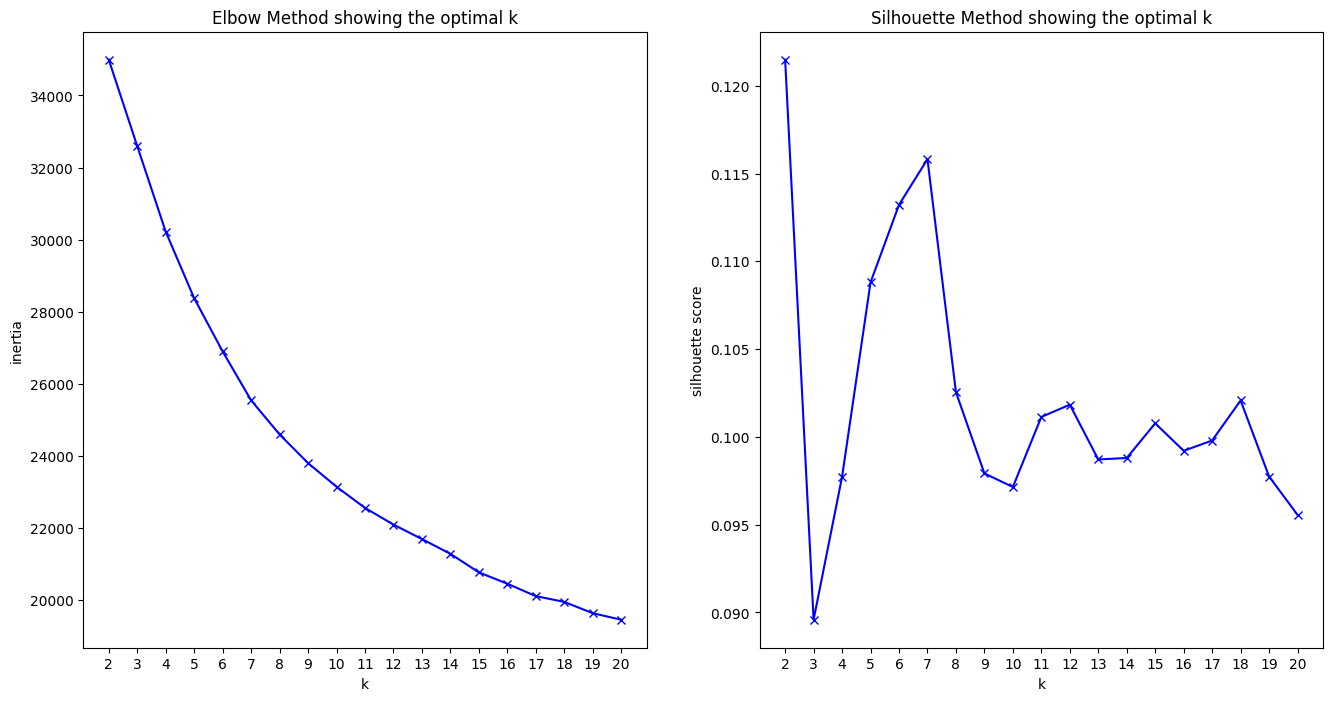

In [226]:
K = range(2, 21)

inertia = []
silhouette = []

path = "kmeans_clustering/"
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)
    print("The new directory is created!")

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234,
                    verbose=1)
    kmeans.fit(X_scaled_df)
    
    filename = "kmeans_" + str(k) + ".pickle" # Path with filename # kmeans_n.pickle
    with open(path+filename, "wb") as file:
        pickle.dump(kmeans,file)

    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))

fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')
plt.show()

From these visuals with KMeans method, would recommend using 7 clusters. 

In [227]:
def load(filename = "filename.pickle"):
    try:
        with open(filename, "rb") as file:
            return pickle.load(file)
    except FileNotFoundError:
        print("File not found!")


# HDBSCAN Model

In [228]:
# Scaling features
scaler = StandardScaler()
scaler.fit(X_num)
X_num_scaled_np = scaler.transform(X_num)
X_num_scaled_df = pd.DataFrame(X_num_scaled_np, columns=X_num.columns)


In [244]:
umap = UMAP(n_components=3) # Creating a reduced dimension df with umap to visualise in 3D
umap.fit(X_num_scaled_df)

umap_transformed = umap.transform(X_num_scaled_df)
df_umap = pd.DataFrame(umap_transformed, columns=['UMAP_1','UMAP_2', 'UMAP_3'])
df_umap.head()

,UMAP_1,UMAP_2,UMAP_3
0,-3.141397,8.918664,1.757053
1,11.437141,7.362126,14.128031
2,-2.243296,13.364578,13.765347
3,-2.237619,13.218413,14.350803
4,-4.179466,7.649534,2.694023


In [245]:
# HDBSCAN clustering
hdbscan = HDBSCAN(min_cluster_size=df_umap.shape[1] * 2, cluster_selection_epsilon=1)
yhat = model.fit_predict(df_umap)

# Add the new 'labels' column
df_umap['labels'] = yhat

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=df_umap['UMAP_1'],
    y=df_umap['UMAP_2'],
    z=df_umap['UMAP_3'],
    mode='markers',
    marker=dict(
        color=df_umap['labels'],
        colorscale='Viridis',
        colorbar=dict(title='labels')
    )
)])

fig.update_layout(scene=dict(xaxis_title='UMAP_1', yaxis_title='UMAP_2', zaxis_title='UMAP_3'),
                  title='UMAP + HDBSCAN 3D Scatter Plot')

fig.show()

In [246]:
# retrieve unique clusters
clusters = np.unique(yhat)
clusters # DBSCAN flags with "-1" noisy data.

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [247]:
print("The Silhouette score of the model is: ",round(silhouette_score(df_umap, model.fit_predict(df_umap)),2))
print("The Calinksi-Harabasz score of the model is: ",round(calinski_harabasz_score(df_umap, model.fit_predict(df_umap)),2))

The Silhouette score of the model is:  0.83
The Calinksi-Harabasz score of the model is:  18762.64


In [248]:
# Saving HDBSCAN model

path = "models/"
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)
    print("The new directory is created!")

filename = "hdbscan.pkl"
with open(path+filename, "wb") as file:
    pickle.dump(hdbscan, file)

In [249]:
# Adding cluster membership to original and 
songs_df['cluster'] = yhat
display(songs_df.head())
X_num_scaled_df['cluster'] = yhat
display(X_num_scaled_df.head())

df_umap['clusters'] = df_umap['labels']
df_umap = df_umap.drop(columns='labels')
display(df_umap.head())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,song_name,artist,hot_song,cluster
0,0.749,0.802,10,-5.780,0,0.202,0.105000,0.000000,0.2960,0.4700,203.934,5q62CK2DoFxdFBzFDCctDE,174357,4,big tyma,Alkaline,True,6
1,0.464,0.602,7,-8.185,1,0.125,0.860000,0.000000,0.1620,0.6640,166.748,1npAOCsqbB618Zz4jOQxZL,162373,4,mozambique drill,Mach-Hommy,True,14
2,0.577,0.692,11,-5.960,1,0.640,0.372000,0.059600,0.0989,0.0658,144.702,5zjdL4aLh3D3wOKeRkZSL6,122483,4,2000 rounds,Ghostemane,True,3
3,0.642,0.694,11,-6.104,1,0.364,0.000335,0.000000,0.3120,0.5680,106.410,2TF0kVvksniUGEdwnBSw2v,143331,4,85 to africa,Jidenna,True,3
4,0.789,0.488,4,-9.093,0,0.227,0.179000,0.000008,0.1040,0.0644,133.114,23NWj2izXAJ4yL6Nah73wf,209453,4,pop style,Drake,True,6


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
0,0.548183,0.739928,1.321553,0.304074,-1.216700,0.302554,-0.293402,-0.285696,0.639797,0.102863,1.806130,-0.448273,0.110677,6
1,-1.265486,-0.396237,0.505355,-0.574889,0.821895,-0.260900,3.255804,-0.285696,-0.233249,0.949581,0.579012,-0.654423,0.110677,14
2,-0.546382,0.115037,1.593619,0.238289,0.821895,3.507658,0.961748,0.041657,-0.644362,-1.661277,-0.148493,-1.340613,0.110677,3
3,-0.132738,0.126399,1.593619,0.185661,0.821895,1.488003,-0.785425,-0.285696,0.744041,0.530587,-1.412108,-0.981985,0.110677,3
4,0.802733,-1.043852,-0.310843,-0.906738,-1.216700,0.485494,0.054467,-0.285652,-0.611134,-1.667387,-0.530891,0.155450,0.110677,6


,UMAP_1,UMAP_2,UMAP_3,clusters
0,-3.141397,8.918664,1.757053,6
1,11.437141,7.362126,14.128031,14
2,-2.243296,13.364578,13.765347,3
3,-2.237619,13.218413,14.350803,3
4,-4.179466,7.649534,2.694023,6


In [250]:
#!pwd